Data Processing

In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [9]:
# Mount drive to import data file
from google.colab import drive
drive.mount('/content/drive')

# Ethan drive mount
# drive.mount('/content/gdrive')

Mounted at /content/drive


In [11]:
# Importing data
# retrieved from https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia?resource=download
import torchvision.transforms as transforms
import torchvision.datasets as d
from torch.utils.data import DataLoader, Dataset, Subset

# https://pytorch.org/vision/0.9/transforms.html
# https://pytorch.org/vision/main/generated/torchvision.tv_tensors.Image.html
# https://discuss.pytorch.org/t/resizing-dataset/75620/4

# transform images to rescale, resize, normalize
transform = transforms.Compose([
    transforms.Resize(256),  # Resize the shortest side to 256 pixels
    transforms.CenterCrop(224),  # Crop the center to 224x224 pixels
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
])

# Load your dataset with the defined transformations
# my path is /content/drive/My Drive/Colab Notebooks/APS360/Data NvsBvsV & /content/drive/My Drive/Colab Notebooks/APS360/Data Augmentation
# dear teammates will have to make their own path with the data that's been shared
# graces path '/content/drive/My Drive/Data Augmentation'
# ETHAN JAN WANG JAN BOYAN ETHAN OH BOY OH BOY path "/content/drive/MyDrive/Uni/Year 2/Sem 2/APS360/Data NvsP"
# Renzo path  "/content/gdrive/MyDrive/Colab Notebooks/APS360/Data NvsP"
dataset = d.ImageFolder("/content/drive/My Drive/Colab Notebooks/APS360/Data NvsBvsV", transform=transform)
dataset_aug = d.ImageFolder("/content/drive/My Drive/Colab Notebooks/APS360/Data Augmentation", transform=transform)

In [18]:
# pick 80/10/10 split, remove 90% of the dataset to reduce size of dataset due to computational cost temporarily
# Rebalanced dataset to 1440 images per class
torch.manual_seed(1000)  # For reproducibility

print(f'Total images: {len(dataset)}')
print(dataset.class_to_idx)

# Split the used portion into train, val, test
train, val, test = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])  # Relative to 'used', sums to 1.0

print(f'Training images: {len(train)}')
print(f'Validation images: {len(val)}')
print(f'Test images: {len(test)}')

print("Data augmentation dataset")
print(dataset_aug.class_to_idx)
print(f'Total images: {len(dataset_aug)}')
train_aug, val_aug, test_aug = torch.utils.data.random_split(dataset_aug, [0.8, 0.1, 0.1])  # 80% train, 10% val, 10% test
print(f'Training images: {len(train_aug)}')
print(f'Validation images: {len(val_aug)}')
print(f'Test images: {len(test_aug)}')

Total images: 4330
{'BACTERIA': 0, 'NORMAL': 1, 'VIRUS': 2}
Training images: 3464
Validation images: 433
Test images: 433
Data augmentation dataset
{'BACTERIAL': 0, 'NORMAL': 1, 'VIRUS': 2}
Total images: 1566
Training images: 1253
Validation images: 157
Test images: 156


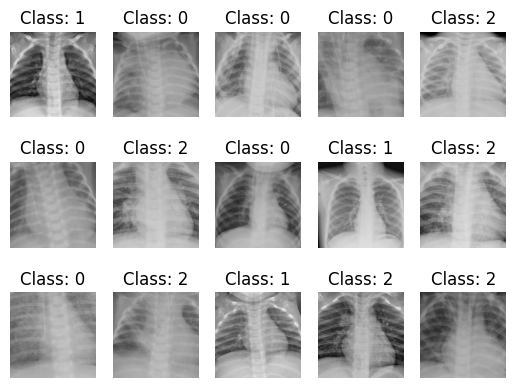

In [ ]:
# Function to denormalize and convert tensor to numpy array
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))  # Convert from Tensor (C, H, W) to Numpy (H, W, C)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # Denormalize
    img = np.clip(img, 0, 1)  # Clip to the valid range [0, 1]
    plt.imshow(img)
    # plt.show()

# Visualize the first 15 images
k = 0
for img, label in train:
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    imshow(img)
    plt.title(f'Class: {label}')  # Set the label as xlabel

    k += 1
    if k > 14:
        break
plt.show()

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        if isinstance(image, torch.Tensor):
          image = transforms.ToPILImage()(image)
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
def dataset_to_numpy(dataset):
    X, y = [], []

    for img, label in dataset:
        img = img.numpy().flatten()  # Convert to NumPy and flatten
        X.append(img)

        y.append(label)

    return np.array(X, dtype=np.float32), np.array(y)

# Convert training and test sets
x_train, y_train = dataset_to_numpy(train)
x_test, y_test = dataset_to_numpy(test)

KeyboardInterrupt: 

Data Augmentation

In [ ]:
# Imports
from diffusers import AutoencoderKL
from PIL import Image
from torchvision import transforms, datasets
import os
from torchvision.utils import save_image

In [ ]:
#I'm using a pretrained vae autoencoder
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
vae.eval()

vae_transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

In [ ]:
augmented_dir = "/content/drive/My Drive/augmented_data" #change your path
os.makedirs(augmented_dir, exist_ok=True)

In [ ]:
class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, save_dir):
        self.dataset = dataset
        self.save_dir = save_dir
        os.makedirs(self.save_dir, exist_ok=True)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        image = vae_transform(image)

        with torch.no_grad():
            latents = vae.encode(image.unsqueeze(0)).latent_dist.sample() #compresses image to latent space + adds noise
            augmented_image = vae.decode(latents).sample.squeeze(0) #reconstructs new image

        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1) #need to remove the vae tranformation
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        augmented_image = augmented_image * std + mean
        augmented_image = augmented_image.clamp(0, 1)

        save_path = os.path.join(self.save_dir, f"aug_{idx}.pt")
        torch.save((augmented_image, label), save_path)

        return augmented_image, label

In [ ]:
augmented_dataset = AugmentedDataset(test_aug, augmented_dir) #just doing it with test
augmented_loader = DataLoader(augmented_dataset, batch_size=32, shuffle=True)

In [ ]:
for i in range(len(augmented_dataset)):
    _, _ = augmented_dataset[i]  #discards returns, just save

KeyboardInterrupt: 

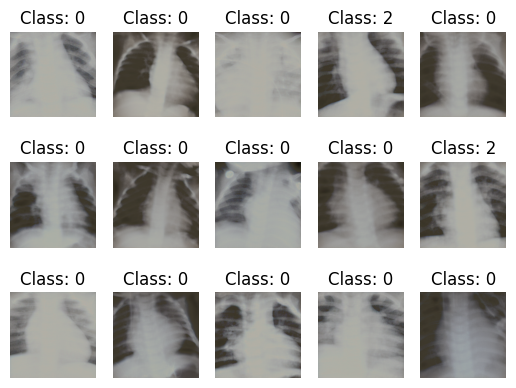

In [ ]:
#visualize 15 images
k = 0

for i in range(15):
    aug_img, label = torch.load(os.path.join(augmented_dir, f"aug_{i}.pt"))

    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(aug_img.permute(1, 2, 0))
    plt.title(f'Class: {label}')
    k += 1

plt.show()

Baseline Model

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

In [ ]:
#confirming class labels
print(np.unique(y_test))

[0 1 2]


To alter the SVM model to classify three classes instead of 2, we have the option of taking two approaches. The first is One-vs-One approach where a classifier is responsible for each possible pair of classes, while ignoring the others. During prediction, a majority vote is taken from each classifier to determine the output. The other approach is the One-vs-All approach where we train a single classifer for each class and compare it against all other classes (grouped as a whole, essentially a negative class). During prediction, each classifier outputs a likelihood score for their respective class and the highest score is selected. When the number of classes is smaller, OvO is more advantagoues, on the other hand OvR scales linearly and is better for larger class sizes. Since we only have 3 classes, we decided to go with the OvO approach.

In [ ]:
# https://scikit-learn.org/stable/modules/svm.html
#Sample data set
x_sample = x_train[:1000]
y_sample = y_train[:1000]


svm_model = SVC(kernel = 'linear', decision_function_shape='ovo')

svm_model.fit(x_sample, y_sample)

prediction = svm_model.predict(x_test)

# Output results
accuracy = svm_model.score(x_test, y_test)
print(f"Model accuracy {accuracy*100}\nModel error {(1-accuracy)*100}")

print(classification_report(y_test, prediction))

Model accuracy 67.4364896073903
Model error 32.56351039260969
              precision    recall  f1-score   support

           0       0.61      0.64      0.62       152
           1       0.87      0.82      0.84       139
           2       0.57      0.57      0.57       142

    accuracy                           0.67       433
   macro avg       0.68      0.68      0.68       433
weighted avg       0.68      0.67      0.68       433



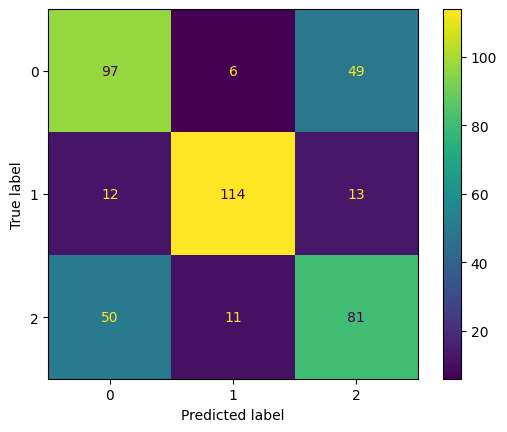

In [ ]:
cm = confusion_matrix(y_test, prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()  # optional color map

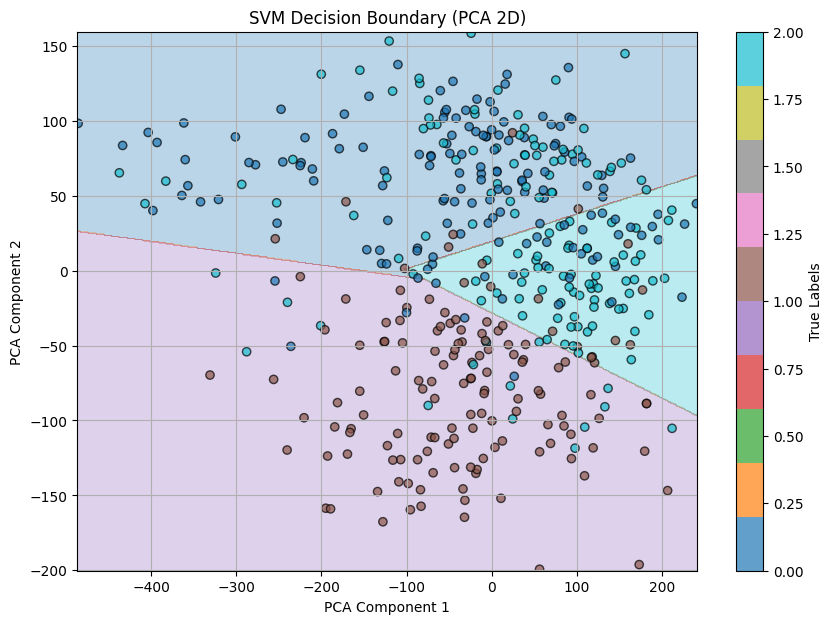

In [ ]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np

# Reduce both train and test sets to 2D
pca = PCA(n_components=2)
x_train_2d = pca.fit_transform(x_sample)
x_test_2d = pca.transform(x_test)

# Train new SVM on reduced data
svm_2d = SVC(kernel='linear', decision_function_shape='ovo')
svm_2d.fit(x_train_2d, y_sample)

# Create meshgrid
x_min, x_max = x_test_2d[:, 0].min() - 1, x_test_2d[:, 0].max() + 1
y_min, y_max = x_test_2d[:, 1].min() - 1, x_test_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))

# Predict on meshgrid to get decision regions
Z = svm_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.figure(figsize=(10, 7))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='tab10')
scatter = plt.scatter(x_test_2d[:, 0], x_test_2d[:, 1], c=y_test, cmap='tab10', edgecolors='k', alpha=0.7)
plt.title("SVM Decision Boundary (PCA 2D)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, label='True Labels')
plt.grid(True)
plt.show()


In [ ]:
# Step 1: Apply PCA to Reduce for Visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(x_train)
support_vectors_pca = pca.transform(svm_model.support_vectors_)  # Only transform support vectors

# Step 2: Create a Smaller Grid for Decision Boundary
x_min, x_max = X_train_pca[:, 0].min(), X_train_pca[:, 0].max()
y_min, y_max = X_train_pca[:, 1].min(), X_train_pca[:, 1].max()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50),  # Reduce grid size from 100x100 to 50x50
                     np.linspace(y_min, y_max, 50))

# Step 3: Predict Directly on PCA-Reduced Grid (No Inverse Transform)
grid_points_pca = np.c_[xx.ravel(), yy.ravel()]
Z = svm_model.predict(pca.inverse_transform(grid_points_pca))  # Predict without large inverse transformation
Z = Z.reshape(xx.shape)

# Step 4: Plot Decision Boundary
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')

classes = np.unique(y_train)
colors = ["blue", "red"]  # or however many classes you have

for cls, col in zip(classes, colors):
    plt.scatter(X_train_pca[y_train == cls, 0],
                X_train_pca[y_train == cls, 1],
                c=col,
                alpha=0.5,
                edgecolors='w',
                label=f"Train Data (Class {cls})")

plt.scatter(support_vectors_pca[:, 0], support_vectors_pca[:, 1], edgecolors='black', facecolors='none', s=100, label="Support Vectors")

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("SVM Decision Boundary")
plt.legend()
plt.show()


Primary Model

In [ ]:
# model name function from lab 2 to help with data checkpoints and plotting
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

# evaluate function from lab 2
def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        """ corr = outputs != labels
        total_err += int(corr.sum())"""
        total_loss += loss.item()
        total_epoch += len(labels)
        _, predicted = torch.max(outputs.data, 1)
        total_err += (predicted != labels).sum().item()
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

# from tut 3
def get_accuracy(model, train=False):
    if train:
        data = train
    else:
        data = val

    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=64):

        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

# train net function from lab 2
def train_net(net, batchsize, lr, epoch, train, val):
    criterion = nn.CrossEntropyLoss()
    optimizer=optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-5)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Convert data to tensors and load the batches
    traindataset = Dataset(train, transform=transform)
    valdataset = Dataset(val, transform=transform)
    trainloader = torch.utils.data.DataLoader(traindataset, batch_size=batchsize, shuffle=True)
    valloader = torch.utils.data.DataLoader(valdataset, batch_size=batchsize, shuffle=True)

    # Set up error and loss arrays
    train_error = np.zeros(epoch)
    train_loss = np.zeros(epoch)
    val_err = np.zeros(epoch)
    val_loss = np.zeros(epoch)

    # Initialize variables to track the best model
    best_val_err = float('inf')
    best_model_path = None

    # Iterate through and train the data
    for epoch_idx in range(epoch):
        total_train_samples = 0
        i = 0
        for image, label in trainloader:
            optimizer.zero_grad()
            output = net(image)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            train_loss[epoch_idx] += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_error[epoch_idx] += (predicted != label).sum().item()
            total_train_samples += len(label)
            i += 1

        # Calculate error and loss for each epoch
        train_loss[epoch_idx] /= (i + 1)
        train_error[epoch_idx] /= total_train_samples
        val_err[epoch_idx], val_loss[epoch_idx] = evaluate(net, valloader, criterion)
        print(f"Epoch {epoch_idx+1}: Train Loss: {train_loss[epoch_idx]}, Train Error: {train_error[epoch_idx]}, Val Loss: {val_loss[epoch_idx]}, Val Error: {val_err[epoch_idx]}")

        # Checkpoint after each epoch
        model_path = get_model_name(net.name, batchsize, lr, epoch_idx)
        torch.save(net.state_dict(), model_path)

        # Check if this epoch's validation error is the best so far
        if val_err[epoch_idx] < best_val_err:
            best_val_err = val_err[epoch_idx]
            best_model_path = f"best_model_{net.name}_bs{batchsize}_lr{lr}_epoch{epoch_idx}_val_err{best_val_err:.4f}.pt"
            torch.save(net.state_dict(), best_model_path)
            print(f"New best model saved at epoch {epoch_idx+1} with validation error: {best_val_err:.4f}")

    # Save the model metrics
    epochs = np.arange(1, epoch + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_error)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

    print(f"Training completed. Best model saved at: {best_model_path}")
    return best_model_path  # Return the path to the best model

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.name = "Net"
        self.conv1 = nn.Conv2d(3, 16, 5)  # in_channels, out_channels, kernel_size
        self.pool = nn.MaxPool2d(2, 2)  # kernel_size, stride
        self.conv2 = nn.Conv2d(16, 32, 5)  # in_channels, out_channels, kernel_size
        self.fc1 = nn.Linear(32 * 53 * 53, 512)
        self.fc2 = nn.Linear(512, 3)
        self.dropout = nn.Dropout(0.5)  # Add dropout
        self.bn1 = nn.BatchNorm1d(512)  # Batch normalization for fc1

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Output: (16, 110, 110)
        x = self.pool(F.relu(self.conv2(x)))  # Output: (32, 53, 53)
        x = x.view(-1, 32 * 53 * 53)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.bn1(x)  # Apply batch normalization
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)
        return x

In [ ]:
#From lab 2 to help plot curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [ ]:
# Check if the model can overfit
small_train = Subset(train, range(10))
small_val = Subset(val, range(10))

net=Net()
train_net(net, 12, 0.001, 20, small_train, small_val)

Epoch 1: Train Loss: 0.7644373178482056, Train Error: 0.9, Val Loss: 1.8825851678848267, Val Error: 0.8
New best model saved at epoch 1 with validation error: 0.8000
Epoch 2: Train Loss: 0.08618728816509247, Train Error: 0.1, Val Loss: 1.8552967309951782, Val Error: 0.7
New best model saved at epoch 2 with validation error: 0.7000
Epoch 3: Train Loss: 0.05909256264567375, Train Error: 0.0, Val Loss: 2.450502872467041, Val Error: 0.7
Epoch 4: Train Loss: 0.02982126735150814, Train Error: 0.0, Val Loss: 2.3175384998321533, Val Error: 0.7
Epoch 5: Train Loss: 0.028727877885103226, Train Error: 0.0, Val Loss: 2.4716687202453613, Val Error: 0.7
Epoch 6: Train Loss: 0.029963454231619835, Train Error: 0.0, Val Loss: 2.564466953277588, Val Error: 0.7
Epoch 7: Train Loss: 0.01806481182575226, Train Error: 0.0, Val Loss: 2.611815929412842, Val Error: 0.8
Epoch 8: Train Loss: 0.02095041051506996, Train Error: 0.0, Val Loss: 2.8199048042297363, Val Error: 0.8
Epoch 9: Train Loss: 0.022221293300390

'best_model_Net_bs12_lr0.001_epoch1_val_err0.7000.pt'

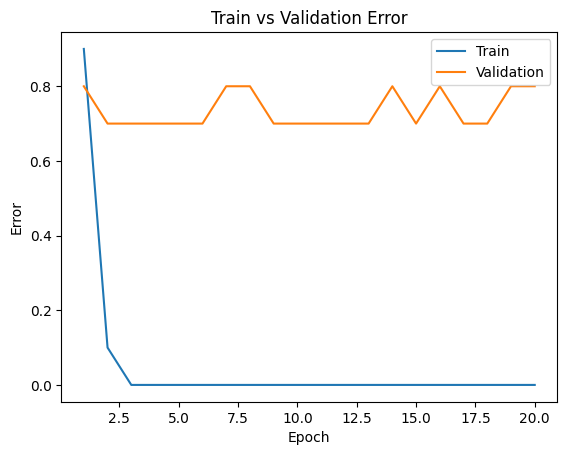

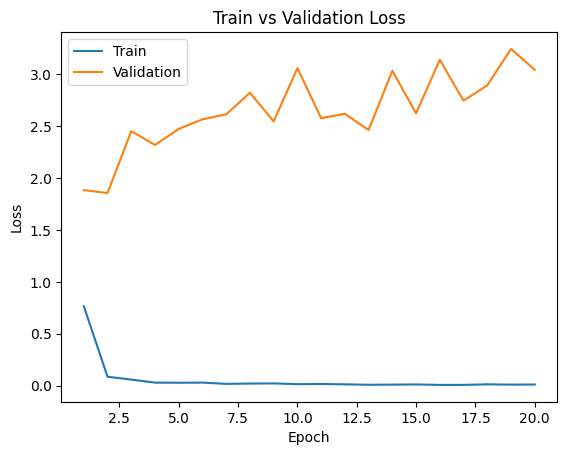

In [ ]:
model_path = get_model_name("Net", batch_size=12, learning_rate=0.001, epoch=19)
plot_training_curve(model_path)

Hyperparameter Tuning

In [ ]:
net1=Net()

train_net(net1, 54, 0.015, 30, train, val)

Epoch 1: Train Loss: 0.9627334475517273, Train Error: 0.6705202312138728, Val Loss: 1.0813534259796143, Val Error: 0.6046511627906976
Epoch 2: Train Loss: 0.9527393132448196, Train Error: 0.6271676300578035, Val Loss: 1.090330958366394, Val Error: 0.7674418604651163
Epoch 3: Train Loss: 0.92756187915802, Train Error: 0.6127167630057804, Val Loss: 1.045494556427002, Val Error: 0.37209302325581395
Epoch 4: Train Loss: 0.8496235683560371, Train Error: 0.4161849710982659, Val Loss: 1.3394662141799927, Val Error: 0.7209302325581395
Epoch 5: Train Loss: 0.788612850010395, Train Error: 0.4653179190751445, Val Loss: 0.8027111291885376, Val Error: 0.37209302325581395
Epoch 6: Train Loss: 0.5246855840086937, Train Error: 0.23121387283236994, Val Loss: 0.8420045375823975, Val Error: 0.37209302325581395
Epoch 7: Train Loss: 1.8991441279649734, Train Error: 0.5751445086705202, Val Loss: 1.0876247882843018, Val Error: 0.6046511627906976
Epoch 8: Train Loss: 0.9608535319566727, Train Error: 0.6473988

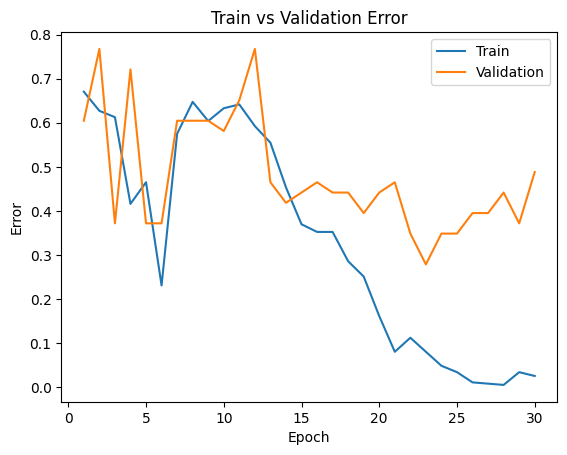

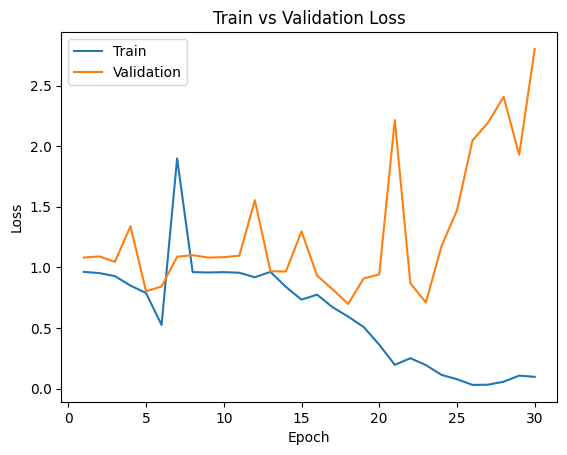

In [ ]:
model_path = get_model_name("Net", batch_size=54, learning_rate=0.015, epoch=29)
plot_training_curve(model_path)

In [ ]:
net2=Net()

train_net(net2, 54, 0.02, 30, train, val)

Epoch 1: Train Loss: 0.9587626606225967, Train Error: 0.6763005780346821, Val Loss: 1.0746095180511475, Val Error: 0.6046511627906976
Epoch 2: Train Loss: 0.9338290691375732, Train Error: 0.5895953757225434, Val Loss: 1.0746054649353027, Val Error: 0.6046511627906976
Epoch 3: Train Loss: 0.8824760466814041, Train Error: 0.5635838150289018, Val Loss: 0.9738593697547913, Val Error: 0.5813953488372093
Epoch 4: Train Loss: 0.7415601387619972, Train Error: 0.4421965317919075, Val Loss: 1.022408366203308, Val Error: 0.4418604651162791
Epoch 5: Train Loss: 0.657524399459362, Train Error: 0.3352601156069364, Val Loss: 0.8606921434402466, Val Error: 0.4418604651162791
Epoch 6: Train Loss: 0.5514022707939148, Train Error: 0.31213872832369943, Val Loss: 0.8107114434242249, Val Error: 0.4186046511627907
Epoch 7: Train Loss: 0.4004211015999317, Train Error: 0.22254335260115607, Val Loss: 0.6203939914703369, Val Error: 0.37209302325581395
Epoch 8: Train Loss: 0.3659417387098074, Train Error: 0.15317

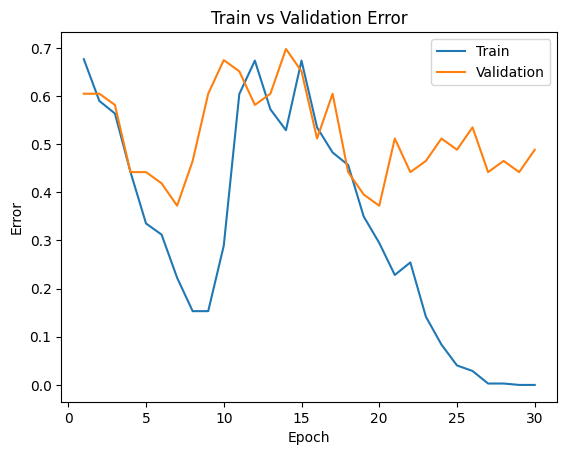

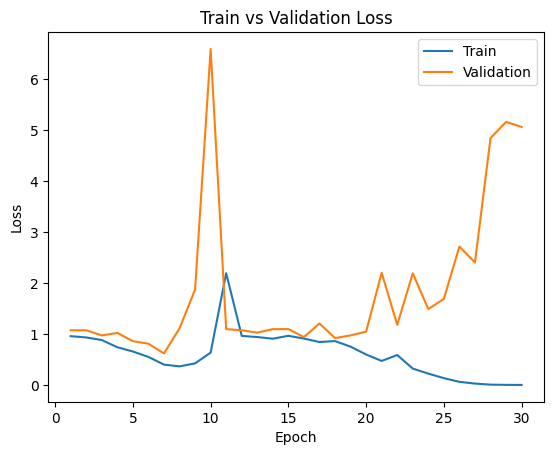

In [ ]:
model_path = get_model_name("Net", batch_size=54, learning_rate=0.02, epoch=29)
plot_training_curve(model_path)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.name = "Net"
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.conv3 = nn.Conv2d(32, 56, 5)
        self.fc1 = nn.Linear(56 * 24 * 24, 512)
        self.fc2 = nn.Linear(512, 3)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 56 * 24 * 24)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x.squeeze()

In [ ]:
net3=Net()

train_net(net3, 54, 0.02, 30, train, val)

Epoch 1: Train Loss: 0.9654484242200851, Train Error: 0.6763005780346821, Val Loss: 1.1017961502075195, Val Error: 0.6976744186046512
Epoch 2: Train Loss: 0.951656386256218, Train Error: 0.6271676300578035, Val Loss: 1.0894057750701904, Val Error: 0.6046511627906976
Epoch 3: Train Loss: 0.9223911166191101, Train Error: 0.5433526011560693, Val Loss: 1.13134765625, Val Error: 0.6976744186046512
Epoch 4: Train Loss: 0.8726663291454315, Train Error: 0.5433526011560693, Val Loss: 0.8997949957847595, Val Error: 0.5116279069767442
Epoch 5: Train Loss: 0.7633600160479546, Train Error: 0.4190751445086705, Val Loss: 1.5860627889633179, Val Error: 0.627906976744186
Epoch 6: Train Loss: 1.0454861521720886, Train Error: 0.5751445086705202, Val Loss: 1.0817718505859375, Val Error: 0.5116279069767442
Epoch 7: Train Loss: 0.8842870965600014, Train Error: 0.5260115606936416, Val Loss: 1.4072778224945068, Val Error: 0.6046511627906976
Epoch 8: Train Loss: 0.8357527032494545, Train Error: 0.4653179190751

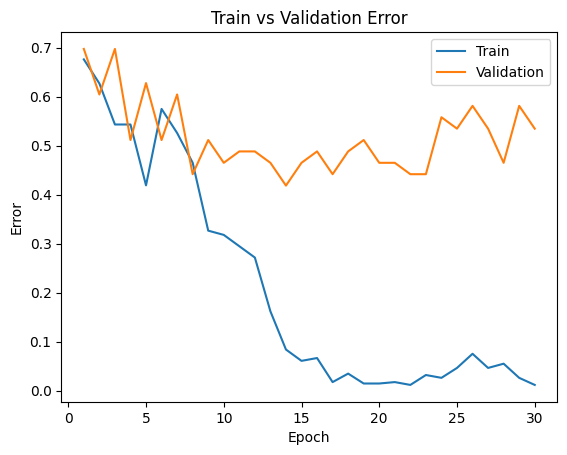

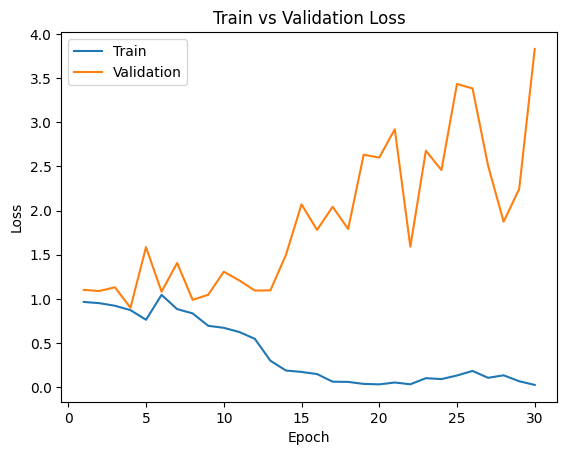

In [ ]:
model_path = get_model_name("Net", batch_size=54, learning_rate=0.02, epoch=29)
plot_training_curve(model_path)

In [ ]:
net4=Net()

train_net(net4, 54, 0.01, 30, train, val)

Epoch 1: Train Loss: 0.9644594043493271, Train Error: 0.7225433526011561, Val Loss: 1.0955890417099, Val Error: 0.7441860465116279
Epoch 2: Train Loss: 0.9503469169139862, Train Error: 0.5606936416184971, Val Loss: 1.0936229228973389, Val Error: 0.5813953488372093
Epoch 3: Train Loss: 0.9338638931512833, Train Error: 0.49710982658959535, Val Loss: 1.0524773597717285, Val Error: 0.4186046511627907
Epoch 4: Train Loss: 0.8927285000681877, Train Error: 0.4479768786127168, Val Loss: 1.0341274738311768, Val Error: 0.6046511627906976
Epoch 5: Train Loss: 0.8720523342490196, Train Error: 0.5491329479768786, Val Loss: 1.145134449005127, Val Error: 0.6511627906976745
Epoch 6: Train Loss: 0.8307304084300995, Train Error: 0.4884393063583815, Val Loss: 1.0813759565353394, Val Error: 0.5813953488372093
Epoch 7: Train Loss: 0.6950819790363312, Train Error: 0.35260115606936415, Val Loss: 0.8838362693786621, Val Error: 0.4418604651162791
Epoch 8: Train Loss: 0.5531842783093452, Train Error: 0.27167630

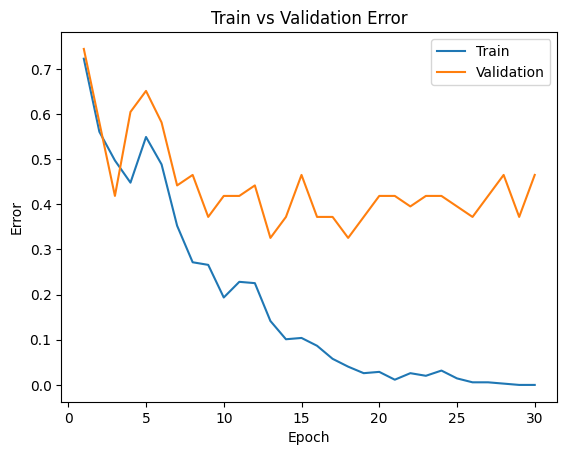

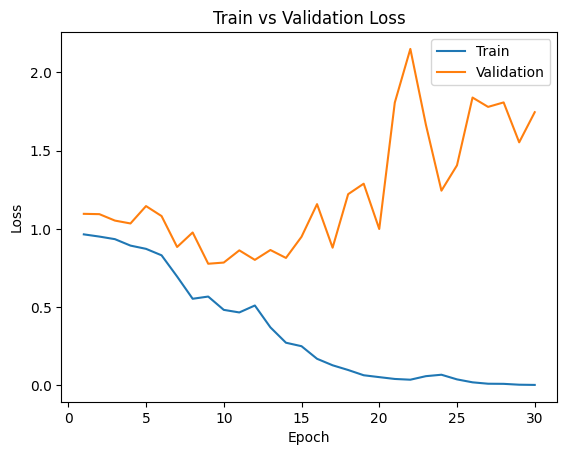

In [ ]:
model_path = get_model_name("Net", batch_size=54, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.name = "Net"
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.conv3 = nn.Conv2d(32, 56, 5)
        self.fc1 = nn.Linear(56 * 24 * 24, 512)
        self.fc2 = nn.Linear(512, 3)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 56 * 24 * 24)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x.squeeze()

In [ ]:
net5=Net()

train_net(net5, 54, 0.005, 30, train, val)

Epoch 1: Train Loss: 0.9649072885513306, Train Error: 0.7254335260115607, Val Loss: 1.1054370403289795, Val Error: 0.7441860465116279
Epoch 2: Train Loss: 0.9576819688081741, Train Error: 0.6647398843930635, Val Loss: 1.0936003923416138, Val Error: 0.5813953488372093
Epoch 3: Train Loss: 0.9464043378829956, Train Error: 0.5260115606936416, Val Loss: 1.0926241874694824, Val Error: 0.5581395348837209
Epoch 4: Train Loss: 0.9312742650508881, Train Error: 0.48554913294797686, Val Loss: 1.0880165100097656, Val Error: 0.6744186046511628
Epoch 5: Train Loss: 0.9040482565760612, Train Error: 0.3988439306358382, Val Loss: 1.0523457527160645, Val Error: 0.6046511627906976
Epoch 6: Train Loss: 0.8679850623011589, Train Error: 0.3988439306358382, Val Loss: 1.0543627738952637, Val Error: 0.5813953488372093
Epoch 7: Train Loss: 0.8742430284619331, Train Error: 0.5173410404624278, Val Loss: 1.422958493232727, Val Error: 0.7441860465116279
Epoch 8: Train Loss: 0.8982605934143066, Train Error: 0.560693

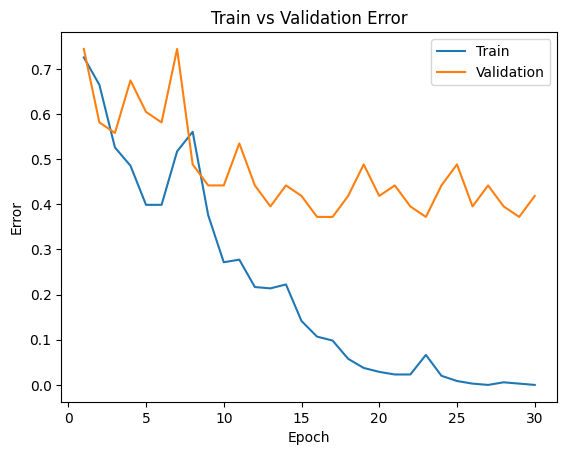

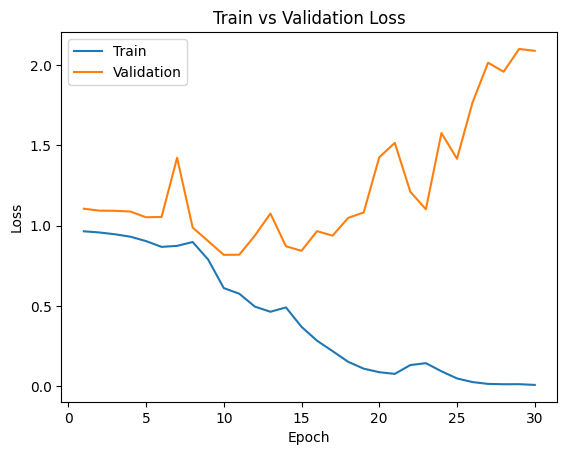

In [ ]:
model_path = get_model_name("Net", batch_size=54, learning_rate=0.005, epoch=29)
plot_training_curve(model_path)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.name = "Net"
        self.conv1 = nn.Conv2d(3, 8, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.conv3 = nn.Conv2d(16, 28, 3)
        self.fc1 = nn.Linear(28 * 26 * 26, 256)
        self.fc2 = nn.Linear(256, 3)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 28 * 26 * 26)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
net6=Net()

train_net(net6, 128, 0.01, 30, train, val)

Epoch 1: Train Loss: 1.04539614299248, Train Error: 0.5964203233256351, Val Loss: 1.0447802543640137, Val Error: 0.5150115473441108
Epoch 2: Train Loss: 0.8928150267436586, Train Error: 0.44341801385681295, Val Loss: 0.7691925168037415, Val Error: 0.3002309468822171
Epoch 3: Train Loss: 0.6446568924805214, Train Error: 0.3086027713625866, Val Loss: 0.7019550800323486, Val Error: 0.3002309468822171
Epoch 4: Train Loss: 0.5717441336861973, Train Error: 0.273094688221709, Val Loss: 0.6557256877422333, Val Error: 0.2540415704387991
Epoch 5: Train Loss: 0.5356733665384096, Train Error: 0.25259815242494227, Val Loss: 0.5914117097854614, Val Error: 0.26558891454965355
Epoch 6: Train Loss: 0.49551967300217725, Train Error: 0.22950346420323325, Val Loss: 0.5753785371780396, Val Error: 0.24480369515011546
Epoch 7: Train Loss: 0.47774480745710174, Train Error: 0.22113163972286373, Val Loss: 0.5855286121368408, Val Error: 0.23556581986143188
Epoch 8: Train Loss: 0.45425494888733176, Train Error: 0

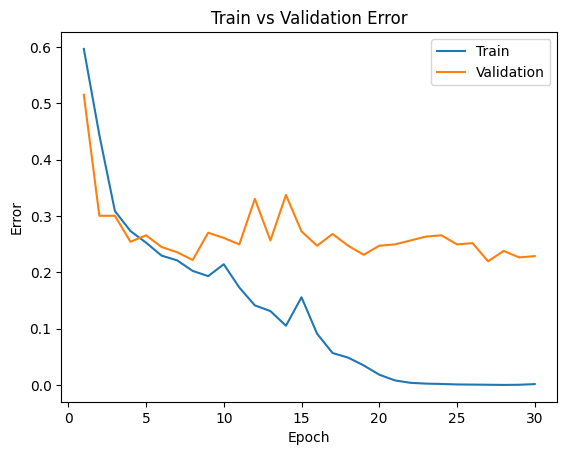

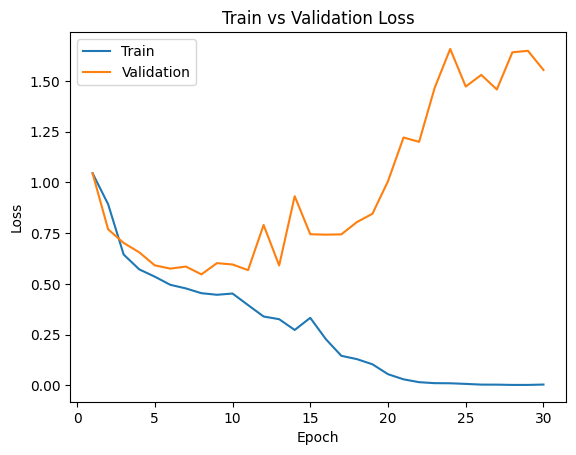

In [ ]:
model_path = get_model_name("Net", batch_size=128, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.name = "Net"
        self.conv1 = nn.Conv2d(3, 4, 3)    # 8 → 4
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)    # 16 → 8
        self.conv3 = nn.Conv2d(8, 14, 3)   # 28 → 14
        self.fc1 = nn.Linear(14 * 26 * 26, 128)  # 256 → 128
        self.fc2 = nn.Linear(128, 3)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 14 * 26 * 26)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
net7=Net()

train_net(net7, 200, 0.005, 30, train, val)

Epoch 1: Train Loss: 1.0387634227150364, Train Error: 0.6368360277136259, Val Loss: 1.1012107928593953, Val Error: 0.6628175519630485
Epoch 2: Train Loss: 1.034084018908049, Train Error: 0.6348152424942263, Val Loss: 1.092431664466858, Val Error: 0.5773672055427251
Epoch 3: Train Loss: 1.0272282989401567, Train Error: 0.569284064665127, Val Loss: 1.0794909397761028, Val Error: 0.605080831408776
Epoch 4: Train Loss: 1.0123451383490312, Train Error: 0.5280023094688222, Val Loss: 1.0560266971588135, Val Error: 0.5288683602771362
Epoch 5: Train Loss: 0.9826948862326773, Train Error: 0.4893187066974596, Val Loss: 1.0065707166989644, Val Error: 0.48267898383371827
Epoch 6: Train Loss: 0.9387083084959733, Train Error: 0.4653579676674365, Val Loss: 1.01565420627594, Val Error: 0.44803695150115475
Epoch 7: Train Loss: 0.8861966980131049, Train Error: 0.4396651270207852, Val Loss: 0.9871737559636434, Val Error: 0.5057736720554272
Epoch 8: Train Loss: 0.7924048147703472, Train Error: 0.3744226327

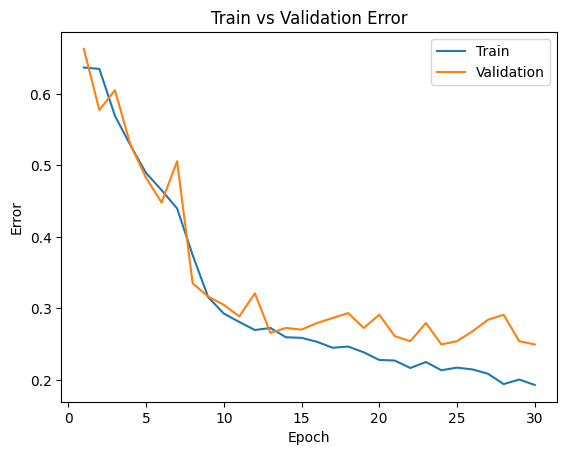

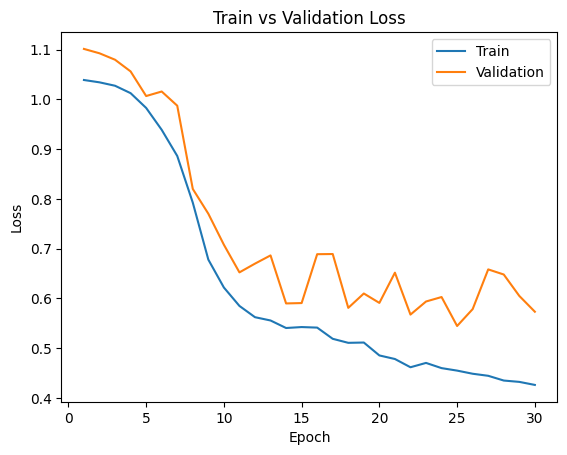

In [ ]:
model_path = get_model_name("Net", batch_size=200, learning_rate=0.005, epoch=29)
plot_training_curve(model_path)

In [ ]:
#class Net(nn.Module):
#    def __init__(self):
#        super(Net, self).__init__()
#        self.name = "Net"
#        self.conv1 = nn.Conv2d(3, 8, 3)
#        self.bn1 = nn.BatchNorm2d(8)
#        self.pool = nn.MaxPool2d(2, 2)
#        self.conv2 = nn.Conv2d(8, 16, 3)
#        self.bn2 = nn.BatchNorm2d(16)
#        self.conv3 = nn.Conv2d(16, 32, 3)
#        self.bn3 = nn.BatchNorm2d(32)
#        self.dropout_conv = nn.Dropout(0.5)
#       self.fc1 = nn.Linear(32 * 26 * 26, 128)
#       self.dropout_fc = nn.Dropout(0.5)
#        self.fc2 = nn.Linear(128, 3)
#
#    def forward(self, x):
#        x = self.pool(F.relu(self.bn1(self.conv1(x))))
#        x = self.pool(F.relu(self.bn2(self.conv2(x))))
#        x = self.pool(F.relu(self.bn3(self.conv3(x))))
#        x = self.dropout_conv(x)
#        x = x.view(-1, 32 * 26 * 26)
#        x = F.relu(self.fc1(x))
#        x = self.dropout_fc(x)
#        x = self.fc2(x)
#        return x

In [ ]:
net8=Net()

train_net(net8, 200, 0.01, 30, train, val)

Epoch 1: Train Loss: 17.837473260728938, Train Error: 0.6454965357967667, Val Loss: 1.0972660382588704, Val Error: 0.6535796766743649
Epoch 2: Train Loss: 1.0394924941815828, Train Error: 0.6720554272517321, Val Loss: 1.097186803817749, Val Error: 0.651270207852194
Epoch 3: Train Loss: 1.035895535820409, Train Error: 0.6579099307159353, Val Loss: 1.099175214767456, Val Error: 0.674364896073903
Epoch 4: Train Loss: 1.018897150692187, Train Error: 0.6203810623556582, Val Loss: 1.1366507212320964, Val Error: 0.6073903002309469
Epoch 5: Train Loss: 1.0065745115280151, Train Error: 0.5932448036951501, Val Loss: 1.0714600086212158, Val Error: 0.6096997690531177
Epoch 6: Train Loss: 1.0002151351226003, Train Error: 0.5889145496535797, Val Loss: 1.080238699913025, Val Error: 0.6189376443418014
Epoch 7: Train Loss: 0.9898125874368768, Train Error: 0.5727482678983834, Val Loss: 1.0687024593353271, Val Error: 0.6027713625866051
Epoch 8: Train Loss: 0.9713323053560758, Train Error: 0.5594688221709

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.name = "Net"
        self.conv1 = nn.Conv2d(3, 4, 3)    # 8 → 4
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)    # 16 → 8
        self.conv3 = nn.Conv2d(8, 14, 3)   # 28 → 14
        self.fc1 = nn.Linear(14 * 26 * 26, 128)  # 256 → 128
        self.fc2 = nn.Linear(128, 3)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.silu(self.conv1(x)))
        x = self.pool(F.silu(self.conv2(x)))
        x = self.pool(F.silu(self.conv3(x)))
        x = x.view(-1, 14 * 26 * 26)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
net10 = Net()
best_model_path = train_net(net10, 200, 0.005, 40, train, val)

KeyboardInterrupt: 

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.name = "Net"
        self.conv1 = nn.Conv2d(3, 4, 3)    # Input: 3 channels, Output: 4
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)    # Output: 8
        self.fc1 = nn.Linear(8 * 54 * 54, 128)  # Adjust based on output size after pooling
        self.fc2 = nn.Linear(128, 3)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 8 * 54 * 54)  # Adjust based on actual size
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
net9 = Net()
best_model_path = train_net(net9, 200, 0.005, 45, train, val)

Epoch 1: Train Loss: 1.034481782662241, Train Error: 0.6556004618937644, Val Loss: 1.0861320892969768, Val Error: 0.5935334872979214
New best model saved at epoch 1 with validation error: 0.5935
Epoch 2: Train Loss: 1.0073608285502385, Train Error: 0.5248267898383372, Val Loss: 1.032230794429779, Val Error: 0.5127020785219399
New best model saved at epoch 2 with validation error: 0.5127
Epoch 3: Train Loss: 0.9481320569389745, Train Error: 0.4350461893764434, Val Loss: 0.9401330351829529, Val Error: 0.4064665127020785
New best model saved at epoch 3 with validation error: 0.4065
Epoch 4: Train Loss: 0.8180104745061774, Train Error: 0.37240184757505773, Val Loss: 0.784298837184906, Val Error: 0.3302540415704388
New best model saved at epoch 4 with validation error: 0.3303
Epoch 5: Train Loss: 0.6923445871001795, Train Error: 0.3253464203233256, Val Loss: 0.7477443019549052, Val Error: 0.3394919168591224
Epoch 6: Train Loss: 0.6038339608593991, Train Error: 0.29618937644341803, Val Loss:

In [ ]:
net10 = Net()
best_model_path = train_net(net10, 200, 0.005, 40, train, val)

Epoch 1: Train Loss: 1.040849622927214, Train Error: 0.6501154734411085, Val Loss: 1.0988867282867432, Val Error: 0.6836027713625866
New best model saved at epoch 1 with validation error: 0.6836
Epoch 2: Train Loss: 1.039591205747504, Train Error: 0.6492494226327945, Val Loss: 1.097345511118571, Val Error: 0.6651270207852193
New best model saved at epoch 2 with validation error: 0.6651
Epoch 3: Train Loss: 1.038969824188634, Train Error: 0.6166281755196305, Val Loss: 1.0965242385864258, Val Error: 0.628175519630485
New best model saved at epoch 3 with validation error: 0.6282
Epoch 4: Train Loss: 1.0381261863206561, Train Error: 0.6068129330254042, Val Loss: 1.095314661661784, Val Error: 0.6166281755196305
New best model saved at epoch 4 with validation error: 0.6166
Epoch 5: Train Loss: 1.036785495908637, Train Error: 0.5782332563510393, Val Loss: 1.0918417771657307, Val Error: 0.535796766743649
New best model saved at epoch 5 with validation error: 0.5358
Epoch 6: Train Loss: 1.03588

In [ ]:
class FinalNet(nn.Module):
    def __init__(self):
        super(FinalNet, self).__init__()
        self.name = "FinalNet"
        self.conv1 = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 9, 3)
        self.fc1 = nn.Linear(9 * 54 * 54, 128)
        self.fc2 = nn.Linear(128, 3)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.silu(self.conv1(x)))
        x = self.pool(F.silu(self.conv2(x)))
        x = x.view(-1, 9 * 54 * 54)
        x = F.silu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
def train_net(net, batchsize, lr, epoch, train, val):
    # Set device to GPU if available, otherwise CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Move model to GPU
    net = net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-5)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Convert data to tensors and load the batches
    traindataset = Dataset(train, transform=transform)
    valdataset = Dataset(val, transform=transform)
    trainloader = torch.utils.data.DataLoader(traindataset, batch_size=batchsize, shuffle=True, num_workers=4, pin_memory=True)
    valloader = torch.utils.data.DataLoader(valdataset, batch_size=batchsize, shuffle=True, num_workers=4, pin_memory=True)

    # Set up error and loss arrays
    train_error = np.zeros(epoch)
    train_loss = np.zeros(epoch)
    val_err = np.zeros(epoch)
    val_loss = np.zeros(epoch)

    # Initialize variables to track the best model
    best_val_err = float('inf')
    best_model_path = None

    # Iterate through and train the data
    for epoch_idx in range(epoch):
        net.train()  # Set model to training mode
        total_train_samples = 0
        i = 0
        for image, label in trainloader:
            # Move data to GPU
            image, label = image.to(device), label.to(device)
            optimizer.zero_grad()
            output = net(image)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            train_loss[epoch_idx] += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_error[epoch_idx] += (predicted != label).sum().item()
            total_train_samples += len(label)
            i += 1

        # Calculate error and loss for each epoch
        train_loss[epoch_idx] /= (i + 1)
        train_error[epoch_idx] /= total_train_samples

        # Evaluate on validation set
        net.eval()  # Set model to evaluation mode
        val_err[epoch_idx], val_loss[epoch_idx] = evaluate(net, valloader, criterion, device)
        print(f"Epoch {epoch_idx+1}: Train Loss: {train_loss[epoch_idx]}, Train Error: {train_error[epoch_idx]}, Val Loss: {val_loss[epoch_idx]}, Val Error: {val_err[epoch_idx]}")

        # Checkpoint after each epoch
        model_path = get_model_name(net.name, batchsize, lr, epoch_idx)
        torch.save(net.state_dict(), model_path)

        # Check if this epoch's validation error is the best so far
        if val_err[epoch_idx] < best_val_err:
            best_val_err = val_err[epoch_idx]
            best_model_path = f"best_model_{net.name}_bs{batchsize}_lr{lr}_epoch{epoch_idx}_val_err{best_val_err:.4f}.pt"
            torch.save(net.state_dict(), best_model_path)
            print(f"New best model saved at epoch {epoch_idx+1} with validation error: {best_val_err:.4f}")

    # Save the model metrics
    epochs = np.arange(1, epoch + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_error)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

    print(f"Training completed. Best model saved at: {best_model_path}")
    return best_model_path

# Update evaluate function for GPU (assuming it’s defined elsewhere)
def evaluate(net, loader, criterion, device):
    net.eval()
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    with torch.no_grad():
        for i, data in enumerate(loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # Move to GPU
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_err += (predicted != labels).sum().item()
            total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

In [ ]:
lastchance = FinalNet()
best_model_path = train_net(lastchance, 200, 0.005, 40, train, val)

Using device: cuda


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1: Train Loss: 1.038193338795712, Train Error: 0.6452078521939953, Val Loss: 1.0964106321334839, Val Error: 0.6789838337182448
New best model saved at epoch 1 with validation error: 0.6790
Epoch 2: Train Loss: 1.0261293712415194, Train Error: 0.6278868360277137, Val Loss: 1.070126215616862, Val Error: 0.6073903002309469
New best model saved at epoch 2 with validation error: 0.6074
Epoch 3: Train Loss: 1.003815393698843, Train Error: 0.5479214780600462, Val Loss: 1.062618573506673, Val Error: 0.581986143187067
New best model saved at epoch 3 with validation error: 0.5820
Epoch 4: Train Loss: 0.9643426819851524, Train Error: 0.4483256351039261, Val Loss: 0.9853043158849081, Val Error: 0.48267898383371827
New best model saved at epoch 4 with validation error: 0.4827
Epoch 5: Train Loss: 0.8912907713337949, Train Error: 0.42984988452655887, Val Loss: 0.9107907215754191, Val Error: 0.3856812933025404
New best model saved at epoch 5 with validation error: 0.3857
Epoch 6: Train Loss: 0.

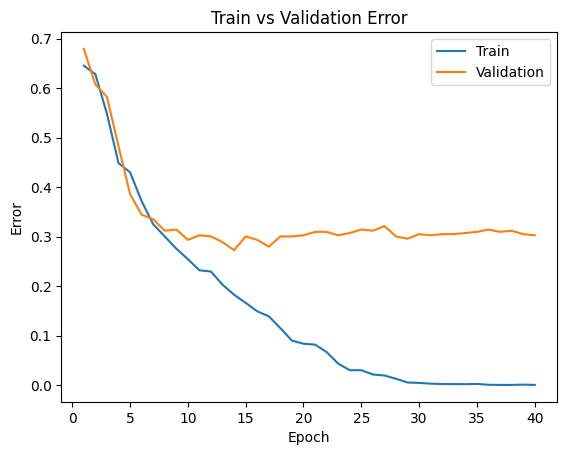

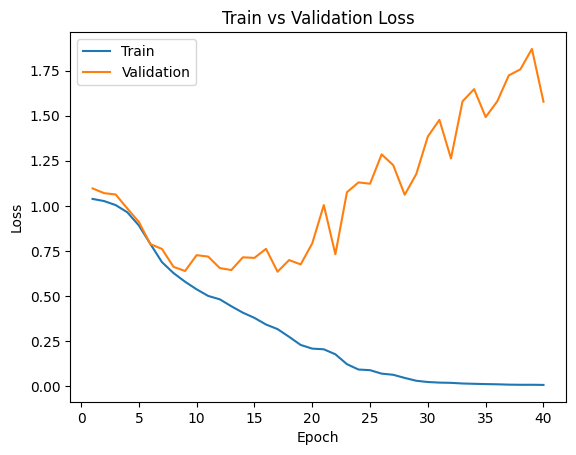

In [ ]:
model_path = get_model_name("FinalNet", batch_size=200, learning_rate=0.005, epoch=39)
plot_training_curve(model_path)

In [ ]:
class FinalNet2(nn.Module):
    def __init__(self):
        super(FinalNet2, self).__init__()
        self.name = "FinalNet2"
        self.conv1 = nn.Conv2d(3, 5, 3)
        self.bn1 = nn.BatchNorm2d(5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 8, 3)
        self.bn2 = nn.BatchNorm2d(8)
        self.fc1 = nn.Linear(8 * 54 * 54, 128)
        self.fc2 = nn.Linear(128, 3)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.silu(self.bn1(self.conv1(x))))
        x = self.pool(F.silu(self.bn2(self.conv2(x))))
        x = x.view(-1, 8 * 54 * 54)
        x = F.silu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
secondchance = FinalNet2()
best_model_path_2 = train_net(secondchance, 200, 0.005, 30, train, val)

Using device: cuda
Epoch 1: Train Loss: 0.8502186066225955, Train Error: 0.4561200923787529, Val Loss: 1.2684108018875122, Val Error: 0.5842956120092379
New best model saved at epoch 1 with validation error: 0.5843
Epoch 2: Train Loss: 0.5976982650003935, Train Error: 0.29734411085450346, Val Loss: 0.6477866172790527, Val Error: 0.26558891454965355
New best model saved at epoch 2 with validation error: 0.2656
Epoch 3: Train Loss: 0.4881889475019355, Train Error: 0.22401847575057737, Val Loss: 0.61401895682017, Val Error: 0.2471131639722864
New best model saved at epoch 3 with validation error: 0.2471
Epoch 4: Train Loss: 0.40635353013088826, Train Error: 0.18648960739030024, Val Loss: 0.753801961739858, Val Error: 0.3464203233256351
Epoch 5: Train Loss: 0.3522752852816331, Train Error: 0.151270207852194, Val Loss: 0.672703206539154, Val Error: 0.2840646651270208
Epoch 6: Train Loss: 0.26077962235400554, Train Error: 0.11172055427251733, Val Loss: 0.7783684134483337, Val Error: 0.290993

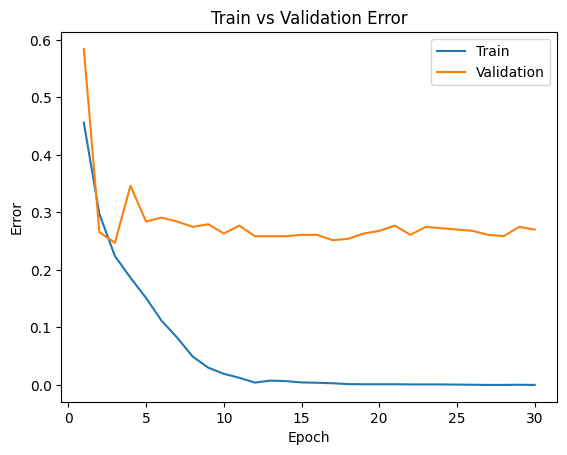

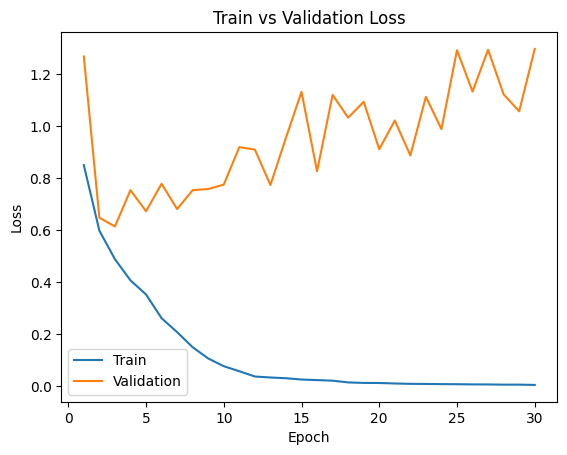

In [ ]:
model_path = get_model_name("FinalNet2", batch_size=200, learning_rate=0.005, epoch=29)
plot_training_curve(model_path)

In [ ]:
def train_net(net, batchsize, lr, epoch, train, val):
    # Set device to GPU if available, otherwise CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Move model to GPU
    net = net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=5e-4)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Convert data to tensors and load the batches
    traindataset = Dataset(train, transform=transform)
    valdataset = Dataset(val, transform=transform)
    trainloader = torch.utils.data.DataLoader(traindataset, batch_size=batchsize, shuffle=True, num_workers=4, pin_memory=True)
    valloader = torch.utils.data.DataLoader(valdataset, batch_size=batchsize, shuffle=True, num_workers=4, pin_memory=True)

    # Set up error and loss arrays
    train_error = np.zeros(epoch)
    train_loss = np.zeros(epoch)
    val_err = np.zeros(epoch)
    val_loss = np.zeros(epoch)

    # Initialize variables to track the best model
    best_val_err = float('inf')
    best_model_path = None

    # Iterate through and train the data
    for epoch_idx in range(epoch):
        net.train()  # Set model to training mode
        total_train_samples = 0
        i = 0
        for image, label in trainloader:
            # Move data to GPU
            image, label = image.to(device), label.to(device)
            optimizer.zero_grad()
            output = net(image)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            train_loss[epoch_idx] += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_error[epoch_idx] += (predicted != label).sum().item()
            total_train_samples += len(label)
            i += 1

        # Calculate error and loss for each epoch
        train_loss[epoch_idx] /= (i + 1)
        train_error[epoch_idx] /= total_train_samples

        # Evaluate on validation set
        net.eval()  # Set model to evaluation mode
        val_err[epoch_idx], val_loss[epoch_idx] = evaluate(net, valloader, criterion, device)
        print(f"Epoch {epoch_idx+1}: Train Loss: {train_loss[epoch_idx]}, Train Error: {train_error[epoch_idx]}, Val Loss: {val_loss[epoch_idx]}, Val Error: {val_err[epoch_idx]}")

        # Checkpoint after each epoch
        model_path = get_model_name(net.name, batchsize, lr, epoch_idx)
        torch.save(net.state_dict(), model_path)

        # Check if this epoch's validation error is the best so far
        if val_err[epoch_idx] < best_val_err:
            best_val_err = val_err[epoch_idx]
            best_model_path = f"best_model_{net.name}_bs{batchsize}_lr{lr}_epoch{epoch_idx}_val_err{best_val_err:.4f}.pt"
            torch.save(net.state_dict(), best_model_path)
            print(f"New best model saved at epoch {epoch_idx+1} with validation error: {best_val_err:.4f}")

    # Save the model metrics
    epochs = np.arange(1, epoch + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_error)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

    print(f"Training completed. Best model saved at: {best_model_path}")
    return best_model_path

# Update evaluate function for GPU (assuming it’s defined elsewhere)
def evaluate(net, loader, criterion, device):
    net.eval()
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    with torch.no_grad():
        for i, data in enumerate(loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # Move to GPU
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_err += (predicted != labels).sum().item()
            total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

In [2]:
class FinalNet3(nn.Module):
    def __init__(self):
        super(FinalNet3, self).__init__()
        self.name = "FinalNet3"
        self.conv1 = nn.Conv2d(3, 5, 3)
        self.bn1 = nn.BatchNorm2d(5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 9, 3)
        self.bn2 = nn.BatchNorm2d(9)
        self.fc1 = nn.Linear(9 * 54 * 54, 128)
        self.fc2 = nn.Linear(128, 3)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.silu(self.bn1(self.conv1(x))))
        x = self.pool(F.silu(self.bn2(self.conv2(x))))
        x = x.view(-1, 9 * 54 * 54)
        x = F.silu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
thirdchance = FinalNet3()
best_model_path_3 = train_net(thirdchance, 200, 0.005, 30, train, val)

Using device: cuda


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1: Train Loss: 5.844371155688637, Train Error: 0.5689953810623557, Val Loss: 0.9763449231783549, Val Error: 0.6304849884526559
New best model saved at epoch 1 with validation error: 0.6305
Epoch 2: Train Loss: 0.9440682530403137, Train Error: 0.5984411085450346, Val Loss: 0.8562453389167786, Val Error: 0.3533487297921478
New best model saved at epoch 2 with validation error: 0.3533
Epoch 3: Train Loss: 0.8181776310268202, Train Error: 0.4142609699769053, Val Loss: 0.7319333553314209, Val Error: 0.34872979214780603
New best model saved at epoch 3 with validation error: 0.3487
Epoch 4: Train Loss: 0.7765004791711506, Train Error: 0.4105080831408776, Val Loss: 0.7335625092188517, Val Error: 0.3140877598152425
New best model saved at epoch 4 with validation error: 0.3141
Epoch 5: Train Loss: 0.7515548467636108, Train Error: 0.3773094688221709, Val Loss: 0.6636553208033243, Val Error: 0.3394919168591224
Epoch 6: Train Loss: 0.7218733649504813, Train Error: 0.3856812933025404, Val Loss

In [ ]:
thirdchance_continue = FinalNet3()

state_dict = torch.load("model_FinalNet3_bs200_lr0.005_epoch29")
thirdchance_continue.load_state_dict(state_dict)
best_model_path_32 = train_net(thirdchance_continue, 200, 0.005, 30, train, val)



Using device: cuda


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1: Train Loss: 3.2542027768335844, Train Error: 0.3071593533487298, Val Loss: 1.5617530345916748, Val Error: 0.2979214780600462
New best model saved at epoch 1 with validation error: 0.2979
Epoch 2: Train Loss: 0.3823949600520887, Train Error: 0.18706697459584296, Val Loss: 0.8103348215421041, Val Error: 0.2817551963048499
New best model saved at epoch 2 with validation error: 0.2818
Epoch 3: Train Loss: 0.34856621842635305, Train Error: 0.1636836027713626, Val Loss: 0.8093646764755249, Val Error: 0.2632794457274827
New best model saved at epoch 3 with validation error: 0.2633
Epoch 4: Train Loss: 0.2888423973008206, Train Error: 0.14780600461893764, Val Loss: 0.868746797243754, Val Error: 0.2702078521939954
Epoch 5: Train Loss: 0.2616251401211086, Train Error: 0.12904157043879907, Val Loss: 0.7820364832878113, Val Error: 0.27713625866050806
Epoch 6: Train Loss: 0.23900690047364487, Train Error: 0.12442263279445727, Val Loss: 0.9706641236941019, Val Error: 0.28868360277136257
Epo

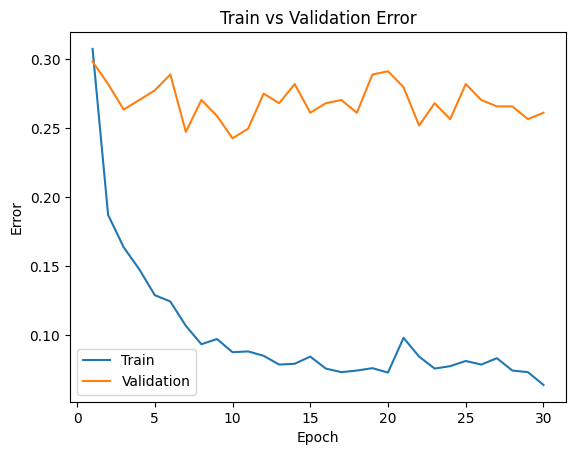

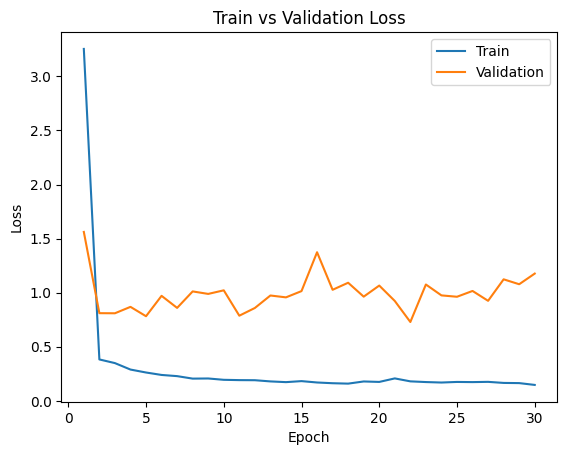

In [ ]:
model_path = get_model_name("FinalNet3", batch_size=200, learning_rate=0.005, epoch=29)
plot_training_curve(model_path)

In [6]:
Final_test_model = FinalNet3()

state_dict = torch.load("best_model_FinalNet3_bs200_lr0.005_epoch9_val_err0.2425.pt")
Final_test_model.load_state_dict(state_dict)


<All keys matched successfully>

In [23]:
def evaluate(net, loader, criterion):
    net.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct = 0
    total = 0

    # Initialize a 3x3 confusion matrix
    conf_matrix = torch.zeros(3, 3)

    with torch.no_grad():
        for inputs, labels in loader:
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update confusion matrix
            for t, p in zip(labels.view(-1), predicted.view(-1)):
               conf_matrix[int(t), int(p)] += 1

    # Calculate metrics
    err = 1 - (correct / total)  # Error rate
    loss = total_loss / len(loader)  # Average loss

    # Calculate Type 1 and Type 2 errors for each class
    type1_errors = []
    type2_errors = []

    for i in range(3):
        # Type 1 error (False Positive Rate): FP / (FP + TN)
        # For class i, FP is sum of non-i columns in row i
        fp = conf_matrix[i].sum() - conf_matrix[i, i]
        # TN is sum of all elements not in row i or column i
        tn = conf_matrix.sum() - conf_matrix[i].sum() - conf_matrix[:, i].sum() + conf_matrix[i, i]
        type1_error = fp / (fp + tn) if (fp + tn) > 0 else 0
        type1_errors.append(type1_error)

        # Type 2 error (False Negative Rate): FN / (FN + TP)
        # For class i, FN is sum of non-i rows in column i
        fn = conf_matrix[:, i].sum() - conf_matrix[i, i]
        tp = conf_matrix[i, i]
        type2_error = fn / (fn + tp) if (fn + tp) > 0 else 0
        type2_errors.append(type2_error)

    # print(f"Labels shape: {labels.shape}, Predicted shape: {predicted.shape}")
    # print(f"Confusion Matrix:\n{conf_matrix}")
    # print(f"Labels: {labels}, Predicted: {predicted}")


    return err, loss, conf_matrix, type1_errors, type2_errors

In [24]:
testloader = torch.utils.data.DataLoader(val, batch_size=32, shuffle=True)

# device = torch.device('cpu')
# Final_test_model = Final_test_model.to(device)

# Then evaluate
criterion = nn.CrossEntropyLoss()
err, loss, conf_matrix, type1_errors, type2_errors = evaluate(Final_test_model, testloader, criterion)

print(f"Accuracy: {(1-err)*100:.2f}%")
print(f"Average Loss: {loss:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Type 1 Errors (False Positive Rates) for each class:", type1_errors)
print("Type 2 Errors (False Negative Rates) for each class:", type2_errors)

Labels shape: torch.Size([17]), Predicted shape: torch.Size([17])
Confusion Matrix:
tensor([[ 13.,   0., 138.],
        [ 31.,   0., 120.],
        [ 28.,   0., 103.]])
Labels: tensor([0, 0, 0, 2, 1, 2, 2, 1, 1, 0, 0, 0, 0, 2, 0, 2, 0]), Predicted: tensor([2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2])
Accuracy: 26.79%
Average Loss: 8.8668
Confusion Matrix:
tensor([[ 13.,   0., 138.],
        [ 31.,   0., 120.],
        [ 28.,   0., 103.]])
Type 1 Errors (False Positive Rates) for each class: [tensor(0.3823), tensor(0.3487), tensor(0.3889)]
Type 2 Errors (False Negative Rates) for each class: [tensor(0.8194), 0, tensor(0.7147)]


In [ ]:
print(f"Confusion Matrix:\n{conf_matrix}")

Confusion Matrix:
tensor([[ 46.,   0., 106.],
        [ 80.,   0.,  59.],
        [ 83.,   0.,  59.]])


<Axes: >

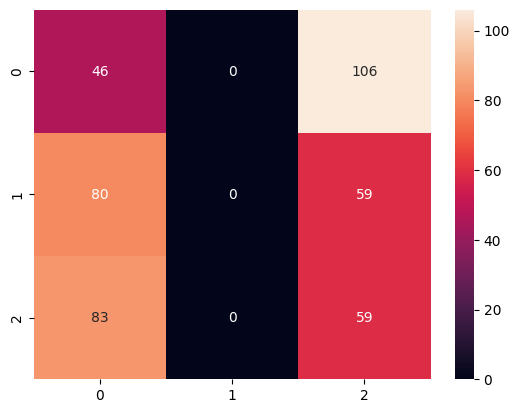

In [ ]:
import seaborn as sns
sns.heatmap(conf_matrix, annot=True, fmt='g')

In [ ]:
Final_test_model.eval()
with torch.no_grad():
    for x, y in testloader:
        outputs = Final_test_model(x)
        print("Sample outputs:", outputs[0])  # Check softmax values

Sample outputs: tensor([  3.6108, -10.1945,   4.8521])
Sample outputs: tensor([ 1.8134, -8.7709,  4.3583])
Sample outputs: tensor([ 0.6102, -6.4005,  2.7303])
Sample outputs: tensor([ 4.0014, -7.8207,  3.9046])
Sample outputs: tensor([ 2.1347, -8.8647,  4.5265])


In [ ]:
import numpy as np

# Print the confusion matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Extract values from the confusion matrix
TN = conf_matrix[0, 0]  # True Negatives
FP = conf_matrix[0, 1]  # False Positives (Type I errors)
FN = conf_matrix[1, 0]  # False Negatives (Type II errors)
TP = conf_matrix[1, 1]  # True Positives

# Calculate total samples
total_samples = TN + FP + FN + TP

# Calculate Type I and Type II error rates
type_1_error = FP / (FP + TN)  # False Positive Rate (Type I error)
type_2_error = FN / (FN + TP)  # False Negative Rate (Type II error)

# Calculate accuracy for reference
accuracy = (TN + TP) / total_samples

# Print error rates
print(f"Type I Error (False Positive Rate): {type_1_error:.4f}")
print(f"Type II Error (False Negative Rate): {type_2_error:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [ ]:
testloader = torch.utils.data.DataLoader(test_aug, batch_size=32, shuffle=True)

err, loss, conf_matrix = evaluate(Final_test_model, testloader, nn.CrossEntropyLoss())
print(f"Confusion Matrix:\n{conf_matrix}")